# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
%%time
storage = paths.AnalysisStorage("weina_production.nc")

CPU times: user 42.3 s, sys: 4.59 s, total: 46.9 s
Wall time: 1min 10s


In [3]:
print "PathMovers:", len(storage.pathmovers)
print "Engines:", len(storage.engines)
print "Samples:", len(storage.samples)
print "Ensembles:", len(storage.ensembles)
print "SampleSets:", len(storage.samplesets)
print "Snapshots:", len(storage.snapshots)
print "Configurations:", len(storage.configurations)
print "Trajectories:", len(storage.trajectories)
print "Networks:", len(storage.networks)

PathMovers: 187
Engines: 1
Samples: 6644
Ensembles: 411
SampleSets: 5000
Snapshots: 158486
Configurations: 79243
Trajectories: 3942
Networks: 1


In [4]:
%%time
mstis = storage.networks.load(0)

CPU times: user 587 µs, sys: 86 µs, total: 673 µs
Wall time: 579 µs


In [5]:
%%time
for cv in storage.cvs:
    print cv.name, cv._store_dict.cache

opA LRUCache(158486/0 of 1000000/0)
phi LRUCache(158486/0 of 1000000/0)
psi LRUCache(158486/0 of 1000000/0)
opB LRUCache(158486/0 of 1000000/0)
opC LRUCache(158486/0 of 1000000/0)
opD LRUCache(158486/0 of 1000000/0)
opE LRUCache(158486/0 of 1000000/0)
opF LRUCache(158486/0 of 1000000/0)
CPU times: user 3.32 ms, sys: 269 µs, total: 3.59 ms
Wall time: 3.55 ms


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 2, 'bin_range' : (0.0, 90) }
mstis.hist_args['pathlength'] = { 'bin_width' : 20, 'bin_range' : (0, 100) }

In [7]:
%%time
mstis.rate_matrix(storage, force=True)

CPU times: user 44.4 s, sys: 342 ms, total: 44.7 s
Wall time: 50.1 s


/Users/jan-hendrikprinz/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/jan-hendrikprinz/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,"{x|opA(x) in [0.0, 10.0]}","{x|opB(x) in [0.0, 10.0]}","{x|opC(x) in [0.0, 10.0]}","{x|opD(x) in [0.0, 10.0]}","{x|opE(x) in [0.0, 10.0]}","{x|opF(x) in [0.0, 10.0]}"
"{x|opA(x) in [0.0, 10.0]}",NaN,0.000174076,1.13528e-05,0,1.61136e-05,0
"{x|opB(x) in [0.0, 10.0]}",7.60491e-05,NaN,4.14859e-06,0,0,0
"{x|opC(x) in [0.0, 10.0]}",0,0,NaN,0.000123484,0,0
"{x|opD(x) in [0.0, 10.0]}",0.000129208,0,0.000655165,NaN,0,0
"{x|opE(x) in [0.0, 10.0]}",0,0,3.25714e-05,0,NaN,3.72886e-05
"{x|opF(x) in [0.0, 10.0]}",0,0,0,0,5.30925e-05,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [10]:
storage.volumes.name_idx

{'A0': {0},
 'A1': {12},
 'A2': {15},
 'A3': {18},
 'A4': {110},
 'B0': {6},
 'B1': {81},
 'B2': {84},
 'B3': {87},
 'B4': {107},
 'C0': {7},
 'C1': {69},
 'C2': {72},
 'C3': {104},
 'D0': {8},
 'D1': {42},
 'D2': {45},
 'D3': {101},
 'E0': {9},
 'E1': {54},
 'E2': {57},
 'E3': {60},
 'E4': {98},
 'F0': {10},
 'F1': {27},
 'F2': {30},
 'F3': {33},
 'F4': {90},
 'all states': {92},
 'all states except A0': {2},
 'all states except B0': {76},
 'all states except C0': {64},
 'all states except D0': {37},
 'all states except E0': {49},
 'all states except F0': {22}}

In [11]:
stateA = storage.volumes["A0"]
stateB = storage.volumes["B0"]
stateC = storage.volumes["C0"]

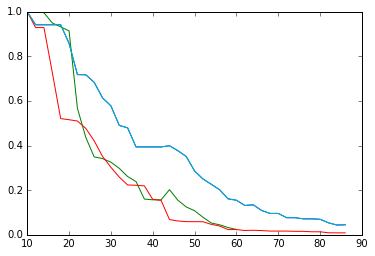

In [12]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

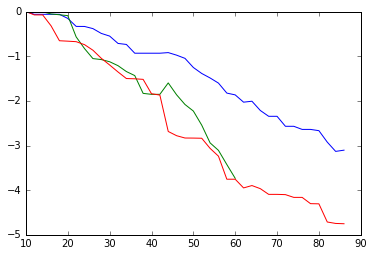

In [13]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [14]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 10.0]}","{x|opB(x) in [0.0, 10.0]}","{x|opC(x) in [0.0, 10.0]}","{x|opD(x) in [0.0, 10.0]}","{x|opE(x) in [0.0, 10.0]}","{x|opF(x) in [0.0, 10.0]}"
"{x|opA(x) in [0.0, 10.0]}",NaN,0.00454545,0.00454545,0.00454545,0.00454545,0.00454545
"{x|opB(x) in [0.0, 10.0]}",0.00615385,NaN,0.00615385,0.00615385,0.00615385,0.00615385
"{x|opC(x) in [0.0, 10.0]}",0.0121547,0.0121547,NaN,0.0121547,0.0121547,0.0121547
"{x|opD(x) in [0.0, 10.0]}",0.0047138,0.0047138,0.0047138,NaN,0.0047138,0.0047138
"{x|opE(x) in [0.0, 10.0]}",0.0104348,0.0104348,0.0104348,0.0104348,NaN,0.0104348
"{x|opF(x) in [0.0, 10.0]}",0.0106195,0.0106195,0.0106195,0.0106195,0.0106195,NaN


### Conditional transition probability

In [15]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 10.0]}","{x|opB(x) in [0.0, 10.0]}","{x|opC(x) in [0.0, 10.0]}","{x|opD(x) in [0.0, 10.0]}","{x|opE(x) in [0.0, 10.0]}","{x|opF(x) in [0.0, 10.0]}"
"{x|opA(x) in [0.0, 10.0]}",NaN,0.2852,0.0186,0,0.0264,0
"{x|opB(x) in [0.0, 10.0]}",0.6086,NaN,0.0332,0,0,0
"{x|opC(x) in [0.0, 10.0]}",0,0,NaN,0.0502,0,0
"{x|opD(x) in [0.0, 10.0]}",0.0708,0,0.359,NaN,0,0
"{x|opE(x) in [0.0, 10.0]}",0,0,0.058,0,NaN,0.0664
"{x|opF(x) in [0.0, 10.0]}",0,0,0,0,0.1756,NaN


In [16]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

,0,1,2,3
"({x|opE(x) in [0.0, 10.0]}, {x|opC(x) in [0.0, 10.0]})",0.0000,0.0000,0.0092,0.0580
"({x|opE(x) in [0.0, 10.0]}, {x|opA(x) in [0.0, 10.0]})",0.0000,0.0000,0.0122,0.0000
"({x|opF(x) in [0.0, 10.0]}, {x|opA(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,0.0000
"({x|opC(x) in [0.0, 10.0]}, {x|opD(x) in [0.0, 10.0]})",0.0070,0.0216,0.0502,NaN
"({x|opD(x) in [0.0, 10.0]}, {x|opF(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,NaN
"({x|opD(x) in [0.0, 10.0]}, {x|opE(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,NaN
"({x|opE(x) in [0.0, 10.0]}, {x|opB(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,0.0000
"({x|opC(x) in [0.0, 10.0]}, {x|opB(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,NaN
"({x|opB(x) in [0.0, 10.0]}, {x|opF(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,0.0000
"({x|opF(x) in [0.0, 10.0]}, {x|opC(x) in [0.0, 10.0]})",0.0000,0.0000,0.0000,0.0000


## Path ensemble properties

In [19]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

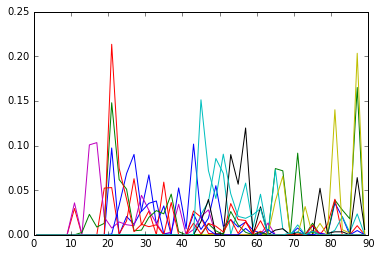

In [20]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [21]:
# add visualization of the sum

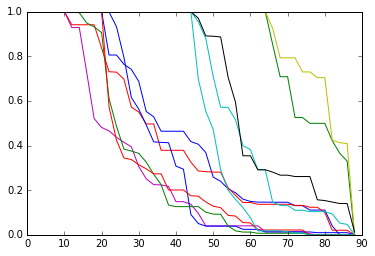

In [22]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

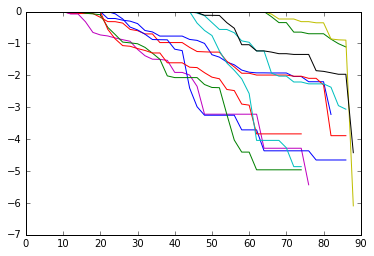

In [23]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

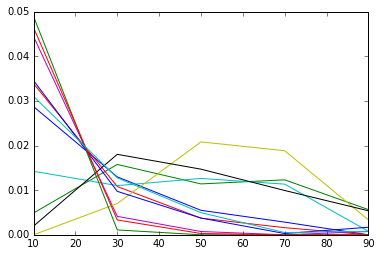

In [24]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

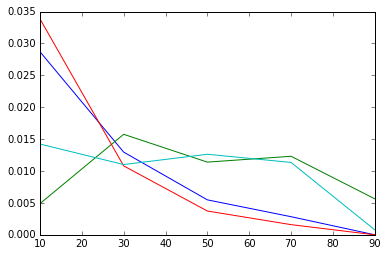

In [25]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [26]:
scheme = storage.schemes[0]

In [27]:
scheme.move_summary(storage)

ms_outer_shooting ran 1.96% of the cycles with acceptance 83/98 (0.84693877551)
repex ran 24.2% of the cycles with acceptance 542/1210 (0.447933884298)
shooting ran 47.26% of the cycles with acceptance 1882/2363 (0.796445196784)
minus ran 2.76% of the cycles with acceptance 117/138 (0.847826086957)
pathreversal ran 23.8% of the cycles with acceptance 1013/1190 (0.851260504202)


In [28]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 2 ran 2.5% of the cycles with acceptance 90/125 (0.72)
OneWayShootingMover I'face 0 ran 1.94% of the cycles with acceptance 80/97 (0.824742268041)
OneWayShootingMover I'face 0 ran 2.04% of the cycles with acceptance 85/102 (0.833333333333)
OneWayShootingMover I'face 1 ran 2.18% of the cycles with acceptance 88/109 (0.807339449541)
OneWayShootingMover I'face 1 ran 2.2% of the cycles with acceptance 79/110 (0.718181818182)
OneWayShootingMover I'face 3 ran 1.62% of the cycles with acceptance 60/81 (0.740740740741)
OneWayShootingMover I'face 0 ran 1.88% of the cycles with acceptance 86/94 (0.914893617021)
OneWayShootingMover I'face 2 ran 2.1% of the cycles with acceptance 77/105 (0.733333333333)
OneWayShootingMover I'face 2 ran 2.26% of the cycles with acceptance 88/113 (0.778761061947)
OneWayShootingMover I'face 1 ran 2.04% of the cycles with acceptance 86/102 (0.843137254902)
OneWayShootingMover I'face 3 ran 2.32% of the cycles with acceptance 80/116 (0.6896551

In [29]:
for mover in scheme.movers['shooting']:
    print mover, scheme.choice_probability[mover]*100

OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 3 2.14132762313
OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 3 2.14132762313
OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 3 2.14132762313
OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 0 2.14132762313
OneWayShootingMover I'face 1 2.14132762313
OneWayShootingMover I'face 2 2.14132762313
OneWayShootingMover I'face 3 2.14132762313


In [30]:
scheme.move_summary(storage, 'minus')

Minus ran 0.52% of the cycles with acceptance 17/26 (0.653846153846)
Minus ran 0.38% of the cycles with acceptance 14/19 (0.736842105263)
Minus ran 0.46% of the cycles with acceptance 22/23 (0.95652173913)
Minus ran 0.5% of the cycles with acceptance 24/25 (0.96)
Minus ran 0.36% of the cycles with acceptance 16/18 (0.888888888889)
Minus ran 0.54% of the cycles with acceptance 24/27 (0.888888888889)


In [31]:
for mover in scheme.movers['minus']:
    print mover, scheme.choice_probability[mover]*100, '%'

Minus 0.428265524625 %
Minus 0.428265524625 %
Minus 0.428265524625 %
Minus 0.428265524625 %
Minus 0.428265524625 %
Minus 0.428265524625 %


In [32]:
scheme.move_summary(storage, 'repex')

ReplicaExchange ran 0.92% of the cycles with acceptance 7/46 (0.152173913043)
ReplicaExchange ran 1.34% of the cycles with acceptance 33/67 (0.492537313433)
ReplicaExchange ran 1.06% of the cycles with acceptance 0/53 (0.0)
ReplicaExchange ran 1.08% of the cycles with acceptance 42/54 (0.777777777778)
ReplicaExchange ran 1.3% of the cycles with acceptance 58/65 (0.892307692308)
ReplicaExchange ran 1.18% of the cycles with acceptance 31/59 (0.525423728814)
ReplicaExchange ran 1.06% of the cycles with acceptance 30/53 (0.566037735849)
ReplicaExchange ran 1.22% of the cycles with acceptance 3/61 (0.0491803278689)
ReplicaExchange ran 1.24% of the cycles with acceptance 0/62 (0.0)
ReplicaExchange ran 0.96% of the cycles with acceptance 9/48 (0.1875)
ReplicaExchange ran 0.98% of the cycles with acceptance 0/49 (0.0)
ReplicaExchange ran 1.28% of the cycles with acceptance 47/64 (0.734375)
ReplicaExchange ran 0.92% of the cycles with acceptance 38/46 (0.826086956522)
ReplicaExchange ran 1.06% 

In [33]:
for mover in scheme.movers['repex']:
    print mover, scheme.choice_probability[mover]*100, '%'

ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %
ReplicaExchange 1.07066381156 %


In [34]:
scheme.move_summary(storage, 'pathreversal')

PathReversal ran 0.96% of the cycles with acceptance 37/48 (0.770833333333)
PathReversal ran 1.0% of the cycles with acceptance 45/50 (0.9)
PathReversal ran 1.1% of the cycles with acceptance 53/55 (0.963636363636)
PathReversal ran 1.22% of the cycles with acceptance 38/61 (0.622950819672)
PathReversal ran 0.84% of the cycles with acceptance 41/42 (0.97619047619)
PathReversal ran 0.96% of the cycles with acceptance 48/48 (1.0)
PathReversal ran 1.04% of the cycles with acceptance 48/52 (0.923076923077)
PathReversal ran 0.98% of the cycles with acceptance 49/49 (1.0)
PathReversal ran 1.12% of the cycles with acceptance 55/56 (0.982142857143)
PathReversal ran 1.42% of the cycles with acceptance 60/71 (0.845070422535)
PathReversal ran 0.94% of the cycles with acceptance 47/47 (1.0)
PathReversal ran 1.0% of the cycles with acceptance 44/50 (0.88)
PathReversal ran 0.74% of the cycles with acceptance 36/37 (0.972972972973)
PathReversal ran 1.28% of the cycles with acceptance 37/64 (0.578125)


In [35]:
for mover in scheme.movers['pathreversal']:
    print mover, scheme.choice_probability[mover]*100, '%'

PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %
PathReversal 1.07066381156 %


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [36]:
repx_net = paths.ReplicaNetwork(storage=storage)

#### Replica exchange mixing matrix

In [37]:
repx_net.mixing_matrix()

,-3,19,20,21,-4,14,15,16,17,-6,...,-5,5,6,7,4,18,8,13,22,27
-3,0.000000,0.010386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
19,0.010386,0.000000,0.034866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
20,0.000000,0.034866,0.000000,0.030415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
21,0.000000,0.000000,0.030415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.017804,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
14,0.000000,0.000000,0.000000,0.000000,0.017804,0.000000,0.031157,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.031157,0.000000,0.005935,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005935,0.000000,0.031899,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031899,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0
-6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,0,0,0,0,0


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

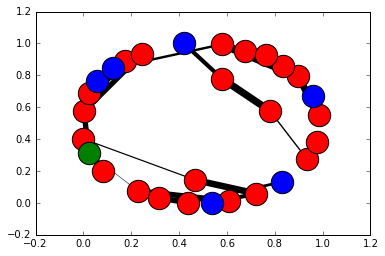

In [38]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [42]:
import openpathsampling.visualize as visualizations
reload(visualizations)
from IPython.display import SVG

history = visualizations.ReplicaHistoryTree(
    storage=storage,
    steps=storage.steps[0:],
    replica=1
)

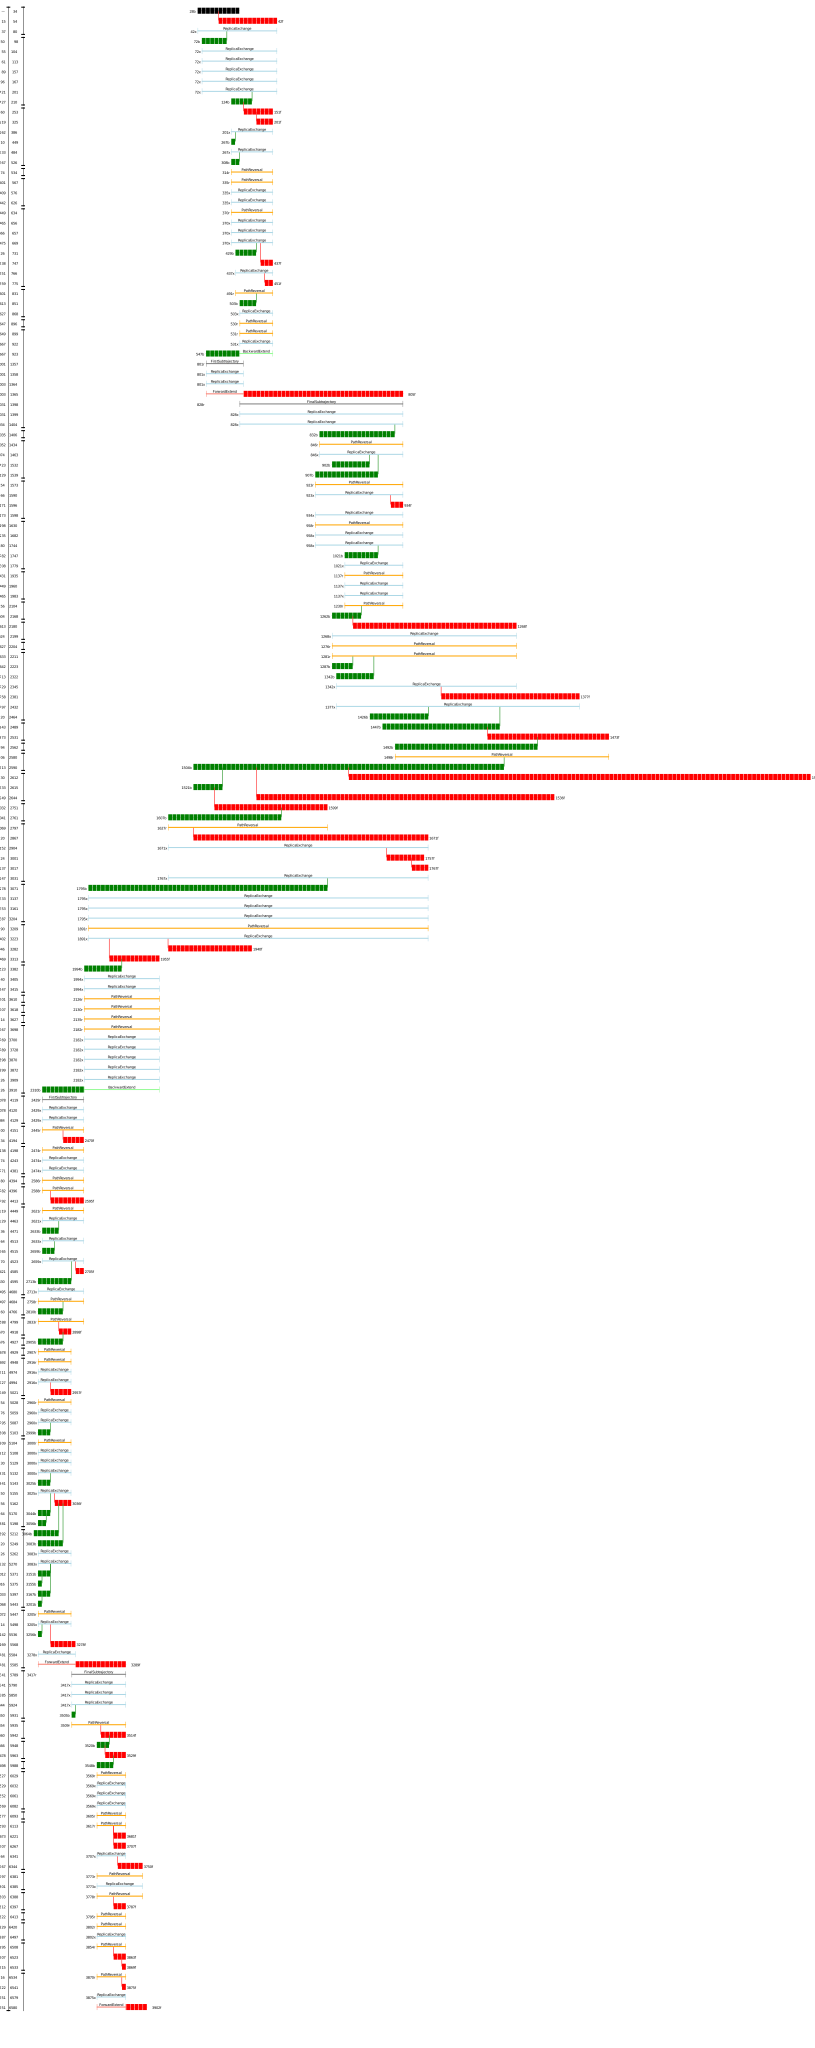

In [43]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [44]:
decorrelated = history.decorrelated_trajectories
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 59 decorrelated trajectories.


### Visualizing trajectories

## Histogramming data (TODO)